In [21]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

### The dataset I'm using for this is from a Kaggle competition (https://www.kaggle.com/mrisdal/fake-news) that uses data scraped from a 'Bullshit meter' by Daniel Sieradski.


In [9]:
## Loading the data
print("Loading Fake news data")
fakeDf = pandas.read_csv("fake.csv")
fakeDf['category'] = fakeDf['type']
fakeDf = fakeDf.dropna()

Loading Fake news data


In [79]:
print("The categories are:", fakeDf.type.unique())

The categories are: ['bias' 'fake' 'bs' 'conspiracy' 'hate' 'junksci' 'state']


### To look at binary classification, we recode the categories into 'BS' and 'Not BS'

In [28]:
# Convert 'category' into a binary variable
fakeDf['category'] = [s == 'bs' for s in fakeDf['type']]
ObamaClintonReleases = fakeDf

# tokenize and normalize
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [80]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)
print("Training dataset has", len(train_data_df), "observations")
print("Testing dataset has", len(test_data_df), "observations")



Training dataset has 3762 observations
Testing dataset has 940 observations


## Logistic Regression

In [30]:
%%time
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])
print("done")
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
print("done")
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
print("done")
train_data_df['pca'] = [r for r in reduced_data]


done
done
done
CPU times: user 11min 3s, sys: 29.6 s, total: 11min 33s
Wall time: 5min 11s


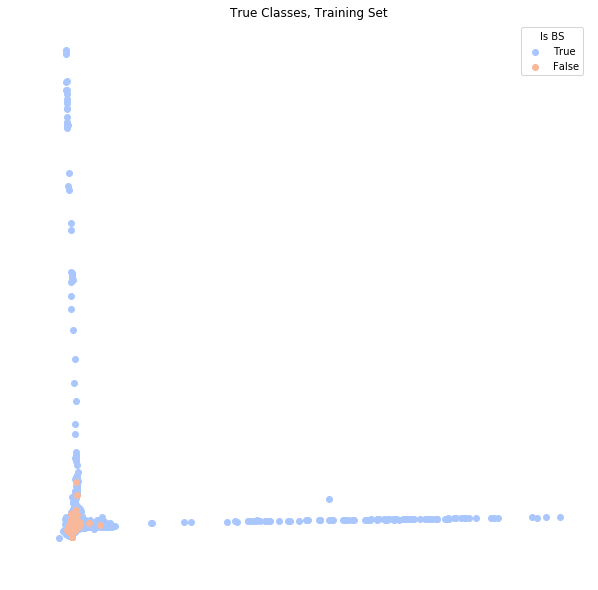

CPU times: user 405 ms, sys: 249 ms, total: 655 ms
Wall time: 783 ms


In [31]:
%%time
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is BS')
plt.title('True Classes, Training Set')
plt.show()

## This makes sense because in the dataset we have available, around 80% of the observations are classified as 'BS'

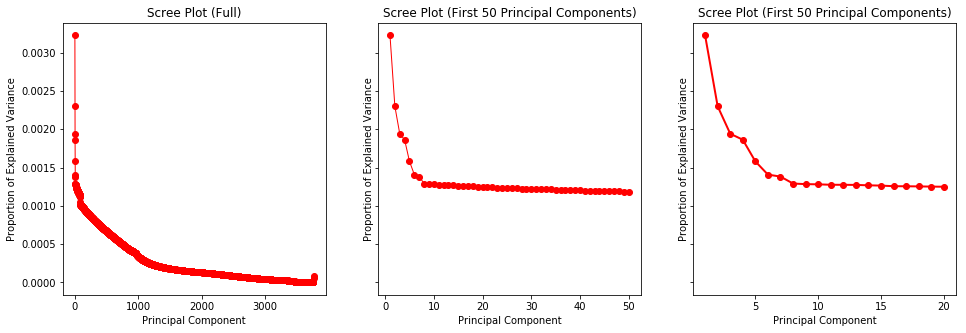

CPU times: user 436 ms, sys: 41.9 ms, total: 478 ms
Wall time: 526 ms


In [32]:
%%time
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

### Logistic Score

In [33]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.8700159489633174

### Score on Testing Data

In [35]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.8617021276595744

### Using 40 dimensions

In [36]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.8700159489633174
Testing:
0.8617021276595744


### Using 100 dimensions

In [37]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8702817650186071
Testing:
0.8617021276595744


### Using 200 dimensions

In [38]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8732057416267942
Testing:
0.8627659574468085


### Using 400 dimensions

In [39]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.873471557682084
Testing:
0.8627659574468085


### We now use the L1 penalty to retain the most individually significant features

In [40]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8987240829346093


In [41]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8797872340425532


### Naive Bayes

In [42]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9053694843168527
Testing:
0.8680851063829788


In [43]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [44]:
# PRECISION
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.9838709677419355

In [45]:
# RECALL
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8772123893805309

In [46]:
# F1 SCORE
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.927485380116959

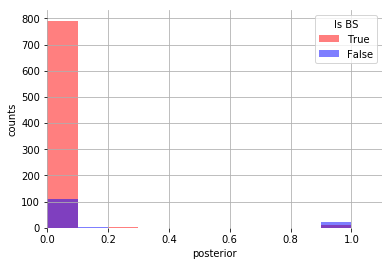

In [47]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is BS")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

## We see that since 'non BS' forms a minority of our dataset, the classifier has 'learned' to classify 'BS' well but has not managed to do the same with 'non-BS'

In [106]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'BS' : [],
    'BS_log_prob' : [],
    'Not BS' : [],
    'Not_BS_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['BS'].append(TFVectorizer.get_feature_names()[i])
    words_dict['BS_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Not BS'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Not_BS_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,BS,BS_log_prob,Not BS,Not_BS_log_prob
0,infowars,-2.219203,der,-3.474362
1,naturalnews,-2.256245,silver,-3.484312
2,crew,-2.355336,connect,-3.514771
3,alex,-2.376389,arabia,-3.525134
4,specials,-2.397895,famous,-3.525134
5,mins,-2.442347,answers,-3.546188
6,tags,-2.537657,apart,-3.546188
7,credits,-2.792549,headed,-3.546188
8,daniel,-2.825339,worry,-3.546188
9,46,-2.859241,80,-3.556883
